Mixture of Gaussians model posterior distribution estimation based on:

Bardenet's paper: Towards scaling up Markov chain Monte Carlo: an adaptive subsampling approach

The mixture model is based on Section 5.1 of "Bayesian Learning via Stochastic Gradient Langevin Dynamics" (2011). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.stats import t
import sys
import scipy.io
from bisect import bisect
import copy

In [2]:
# Bardenet's 14' Paper
class adaptive_mh14:
    def __init__(self,x):
        self.X = x
        self.N = x.shape[0]
    
    def randomWalkProposer(self, theta, eps_sq):
        noise = np.random.multivariate_normal(np.array([0,0]), eps_sq).reshape((2,1))
        return theta + noise
    
    def log_p(self, theta, theta_var):
        '''
        log prior : log(p(\theta))
        '''
        Sigma = np.array([[theta_var[0],0],[0,theta_var[1]]])
        res_first_part = -1.0 * np.log( 2.0 * np.pi * np.sqrt(np.linalg.det(Sigma)) ) 
        res_second_part = -0.5 * (theta.T).dot(np.linalg.inv(Sigma)).dot(theta)
        return res_first_part + res_second_part
        
    
    def log_ll(self, X, theta, var_X):
        '''
        function to calculate log likelihood term: \sum_{i=1}^b{log(p(x_i|\theta))}
        input: var_X : variance of x : var_X = 2
        '''
        X_all = X.reshape((len(X),1))
        ll_constant = 1.0 / (np.sqrt(2.0 * np.pi * var_X) * 2.0 )
        L = ll_constant * ( np.exp(-0.5/var_X * (X_all-theta[0])**2) + \
                           np.exp(-0.5/var_X *(X_all-(theta[0]+theta[1]))**2) )
        log_likelihood = np.sum(np.log(L))
        return log_likelihood
    
    
    def calculate_c_theta(self, theta_c, theta_p, var_X):
        '''
        function to calculate C_{\theta, \theta'} according to the paper
        '''
        res = 0
        for i in range(self.N):
            x = np.array([[self.X[i]]])
            temp = np.abs( self.log_ll(x, theta_c, var_X) - self.log_ll(x, theta_p, var_X) )
            if temp > res :
                res = temp
        return res
    
    
    def calculate_ct(self, theta_c, theta_p, X_mini, var_X, delta_t, t):
        # use the first part of equation (9) to approximate c_t value
        # where \sigma_t is the standard deviation of log(p(x_i|\theta')/p(x_i|\theta))
        
        # first calcualte \sigma_t
        log_llhood_c = [self.log_ll(np.asarray([x]), theta_c, var_X) for x in X_mini]
        log_llhood_p = [self.log_ll(np.asarray([x]), theta_p, var_X) for x in X_mini]
        log_llhood = np.asarray(log_llhood_p) - np.asarray(log_llhood_c)
        sigma_t = np.std(log_llhood)
        
        ct = sigma_t * 1.0 * np.sqrt(2.0 * np.log(3.0/delta_t) / t)
        
        return ct
  
    def function_phi(self, theta_c, theta_p, theta_var):
        '''
        function_phi = 1/n * log[ u * p(\theta) / p(\theta')]
        since we use a random walk proposer, so q(\theta'|\theta) = q(\theta|\theta')
        
        input: theta_c: current theta value
               theta_p: proposed theta value
               theta_var: variance of theta : [10,1]
        '''
        u = np.random.random()
        phi = 1.0/self.N * ( np.log(u) + self.log_p(theta_c, theta_var) - self.log_p(theta_p, theta_var) )
        return phi
    
    def posterior_estimation(self, num_pass, theta_start, eps_sq, theta_var, var_X, p, delta, gamma, temperature):
        '''
        function to perform posteriro estimation
        input: b : minibatch size
               p : a value to calculate delta_t
               temperature
        '''
        theta = theta_start
        theta_list = copy.deepcopy(theta_start)
        batch_size = []
        for k in range(num_pass):
            # print k
            data = self.X
            N = data.shape[0]
            theta_new = self.randomWalkProposer(theta, eps_sq)
            phi = self.function_phi(theta, theta_new, theta_var)
            t = 0
            t_look = 0.0
            A_star = 0.0
            b = 1   # initialize batchsize to 1
            done = False
            while done == False:
                sample_index = np.random.choice(data.shape[0], b-t, replace=False)
                X_mini = data[sample_index]
                data = np.delete(data, sample_index)
                A_star = 1.0 / b * ( t*A_star + 1.0/temperature * self.log_ll(X_mini,theta_new,var_X)*1.0\
                                    - 1.0/temperature * self.log_ll(X_mini, theta, var_X)*1.0 )
                t = b
                t_look = t_look + 1.0
                # calcualte ct                
                # previous method
                '''
                CTT =  self.calculate_c_theta(theta, theta_new, var_X)
                ft = (len(X_mini) -1.0)/self.N
                delta_t_look = (p-1.0)/(p * np.power(t_look,p) *1.0 ) * delta
                
                c = 2 * CTT * np.sqrt( ((1.0- ft) * np.log(2.0/delta_t_look)) / (2*t) )
                
                '''
                # later method
                delta_t_look = (p-1.0)/(p * np.power(t_look,p) ) * delta
                c = self.calculate_ct(theta, theta_new, X_mini, var_X, delta_t_look, t_look)
                
                # finished ct calculation
                
                
                
                b = min(self.N, np.ceil(gamma * t) )
                
                if np.abs(A_star - phi) >= c or b >= self.N :
                    done = True
            if A_star > phi :
                theta = theta_new
            else:
                theta = theta
            theta_list = np.concatenate((theta_list, theta), axis=1)
            batch_size.append(b)
        return (theta_list, batch_size)                

In [3]:
# Generate data
N = 10000 # number of points
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1
X = np.zeros(N)
i = 0
while i < N :
    u = np.random.random()
    if (u<0.5):
        X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
        i = i + 1
    else:
        X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))
        i = i + 1

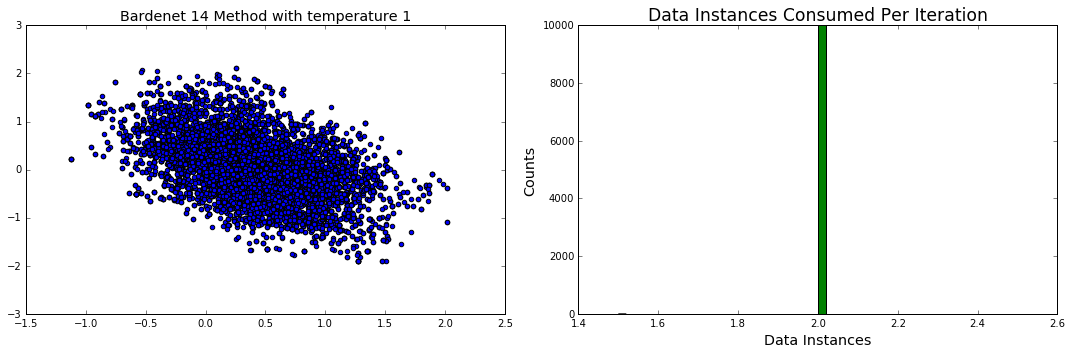

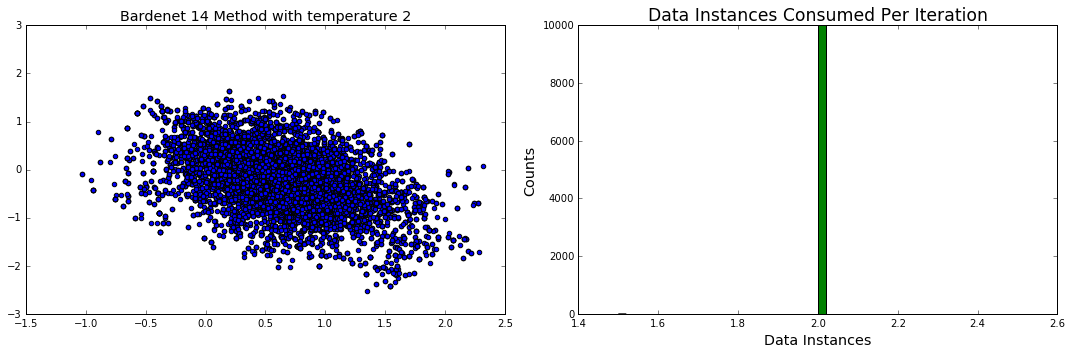

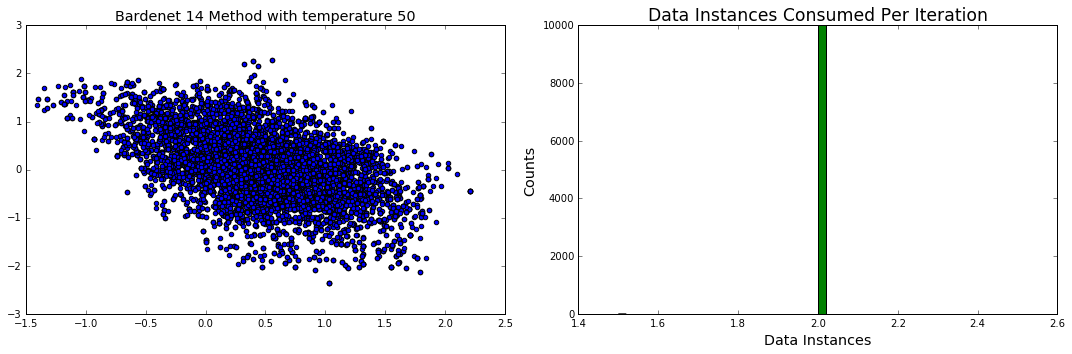

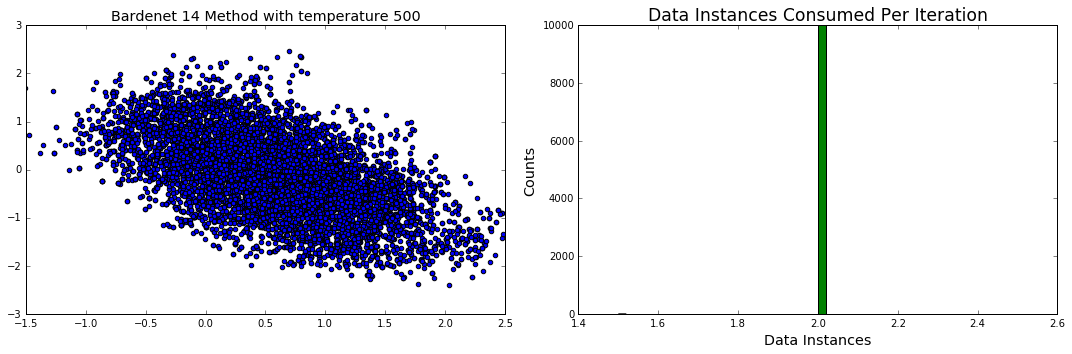

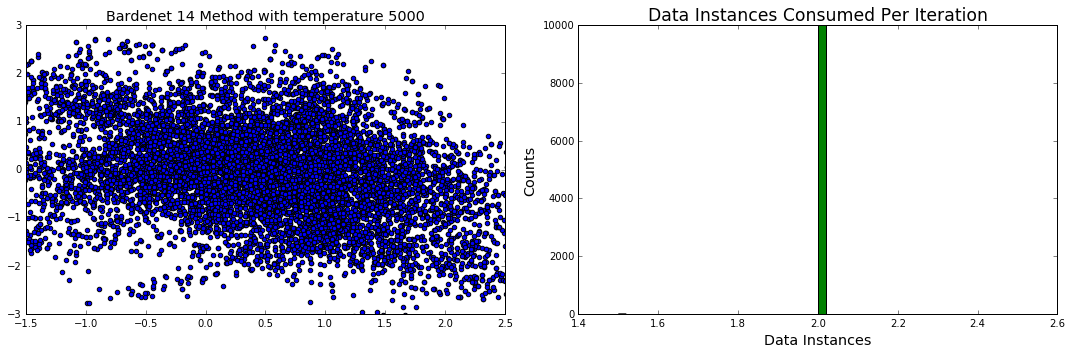

In [4]:
# ************** Run Bardenet 14' Paper *************
num_passes = 10000
rw_eps = 0.03 * np.eye(2)
theta_start = np.array([[0.5],[0]])
theta_var = np.array([10,1])
var_X = 2
p = 2 # according to the paper p > 1, delta = 0.01, gamma= 2
delta = 0.01
gamma = 2 
temperature = 50
bard_test = adaptive_mh14(X)

# do estimation
for temperature in [1,2,50,500,5000]:
    (posterior, data_consume) = \
    bard_test.posterior_estimation(num_passes, theta_start, rw_eps, theta_var, var_X, p, delta, gamma, temperature)

    fig, axarr = plt.subplots(1,2,figsize=(15,5))
    axarr[0].set_title("Bardenet 14 Method with temperature " + str(temperature), size="x-large")
    axarr[0].scatter(posterior[0], posterior[1])
    axarr[0].set_xlim([-1.5,2.5])
    axarr[0].set_ylim([-3,3])
    dataconsume = np.asarray(data_consume)
    axarr[1].set_title("Data Instances Consumed Per Iteration", size="xx-large")
    axarr[1].hist(data_consume, bins=50, facecolor ='green')
    axarr[1].set_xlabel("Data Instances", size="x-large")
    axarr[1].set_ylabel("Counts", size="x-large")
    plt.tight_layout()
    plt.show()